In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [2]:
# Step 1: Data Preparation
# Load the Kuzushiji-MNIST dataset from TensorFlow Datasets
dataset, info = tfds.load("kmnist", with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

# Function to preprocess dataset and convert it to numpy arrays
def preprocess_data(dataset):
    images = []
    labels = []
    for image, label in tfds.as_numpy(dataset):
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)

# Preprocess the dataset
train_images, train_labels = preprocess_data(train_dataset)
test_images, test_labels = preprocess_data(test_dataset)

# Flatten the 28x28 images to a 784-dimensional vector and normalize pixel values between 0 and 1
train_images = train_images.reshape(-1, 28*28).astype('float32') / 255.0
test_images = test_images.reshape(-1, 28*28).astype('float32') / 255.0

# Convert labels to one-hot encoding
train_labels_one_hot = to_categorical(train_labels, 10)
test_labels_one_hot = to_categorical(test_labels, 10)

# Split the training data (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels_one_hot, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", test_images.shape)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/kmnist/incomplete.J0EPNY_3.0.1/kmnist-train.tfrecord*...:   0%|          |…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/kmnist/incomplete.J0EPNY_3.0.1/kmnist-test.tfrecord*...:   0%|          | …

Dataset kmnist downloaded and prepared to /root/tensorflow_datasets/kmnist/3.0.1. Subsequent calls will reuse this data.
Training data shape: (48000, 784)
Validation data shape: (12000, 784)
Test data shape: (10000, 784)


In [3]:
# Step 2: Radial Basis Function (RBF) Network Implementation
# Define a Gaussian RBF function
def gaussian_rbf(x, c, s):
    distance = np.linalg.norm(x - c, axis=1)
    return np.exp(- (distance ** 2) / (2 * (s ** 2)))

# RBF Network class definition
class RBFNetwork:
    def __init__(self, k, input_shape, output_shape):
        self.k = k  # Number of RBF units (centers)
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.centers = None
        self.sigma = None
        self.weights = np.random.randn(k, output_shape)

    # Fit the model using K-Means to determine centers
    def fit(self, X_train, y_train):
        # Use K-means to find RBF centers
        kmeans = KMeans(n_clusters=self.k, random_state=42).fit(X_train)
        self.centers = kmeans.cluster_centers_

        # Sigma is the average distance between RBF centers
        self.sigma = np.mean([np.linalg.norm(self.centers[i] - self.centers[j])
                              for i in range(self.k) for j in range(self.k)])

        # Create the design matrix G
        G = np.zeros((X_train.shape[0], self.k))
        for i in range(self.k):
            G[:, i] = gaussian_rbf(X_train, self.centers[i], self.sigma)

        # Solve for the weights using the pseudo-inverse
        self.weights = np.linalg.pinv(G).dot(y_train)

    # Prediction function
    def predict(self, X):
        G = np.zeros((X.shape[0], self.k))
        for i in range(self.k):
            G[:, i] = gaussian_rbf(X, self.centers[i], self.sigma)
        output = G.dot(self.weights)
        return np.argmax(output, axis=1)

In [4]:
# Step 3: Training
# Define number of RBF units
k = 100  # This can be tuned to see its effect on performance

# Create and train the RBF network
rbf_net = RBFNetwork(k=k, input_shape=X_train.shape[1], output_shape=10)
rbf_net.fit(X_train, y_train)

Validation Accuracy: 84.42%
Test Accuracy: 69.32%
Confusion Matrix for Test Set:
 [[717   1   2   9  29  65   5  69  88  15]
 [  5 734  42  10  33   7  90   7  32  40]
 [ 10  64 637  61  20  15  81  29  60  23]
 [  1  42  87 751  12   5  13   6  71  12]
 [ 82  70  39  24 631   7  40  15  50  42]
 [  6  74 115  37  18 651  35   2  51  11]
 [  5  41  81  10  36   5 784  19  10   9]
 [ 19  27  14   8 151   4  44 531 156  46]
 [ 11  35  26  29   1  18  46   7 813  14]
 [  6  59  88   3  50   8  29  33  41 683]]


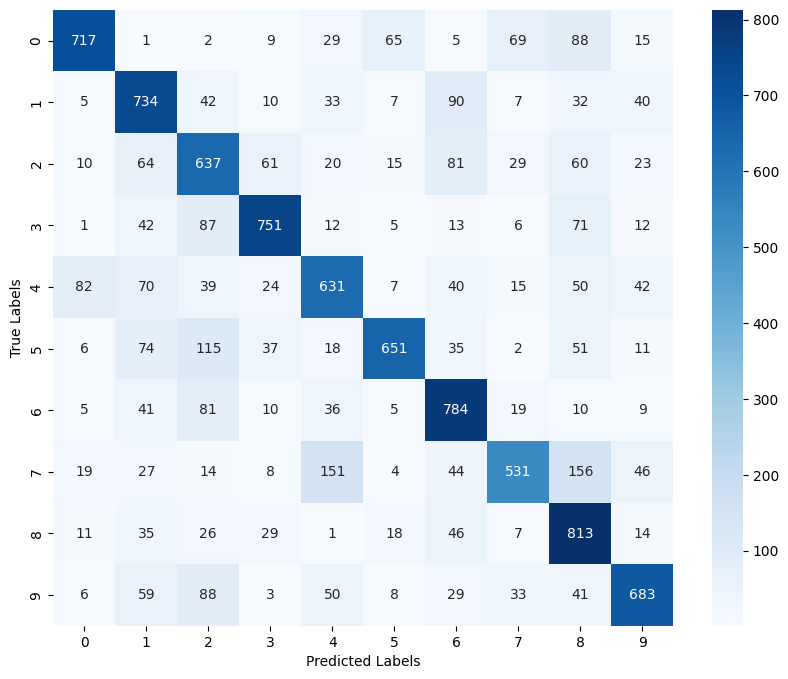

In [5]:
# Step 4: Evaluation
# Make predictions on the validation and test sets
y_val_pred = rbf_net.predict(X_val)
y_test_pred = rbf_net.predict(test_images)

# Convert one-hot encoded labels back to original labels for comparison
y_val_true = np.argmax(y_val, axis=1)
y_test_true = np.argmax(test_labels_one_hot, axis=1)

# Compute accuracy for validation and test sets
val_accuracy = accuracy_score(y_val_true, y_val_pred)
test_accuracy = accuracy_score(y_test_true, y_test_pred)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Confusion matrix for test set
conf_matrix = confusion_matrix(y_test_true, y_test_pred)
print("Confusion Matrix for Test Set:\n", conf_matrix)

# Plot confusion matrix
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Training with 10 RBF units...
Validation Accuracy with 10 RBF units: 63.94%
Training with 50 RBF units...
Validation Accuracy with 50 RBF units: 80.11%
Training with 100 RBF units...
Validation Accuracy with 100 RBF units: 84.42%
Training with 200 RBF units...
Validation Accuracy with 200 RBF units: 88.17%
Training with 300 RBF units...
Validation Accuracy with 300 RBF units: 89.75%


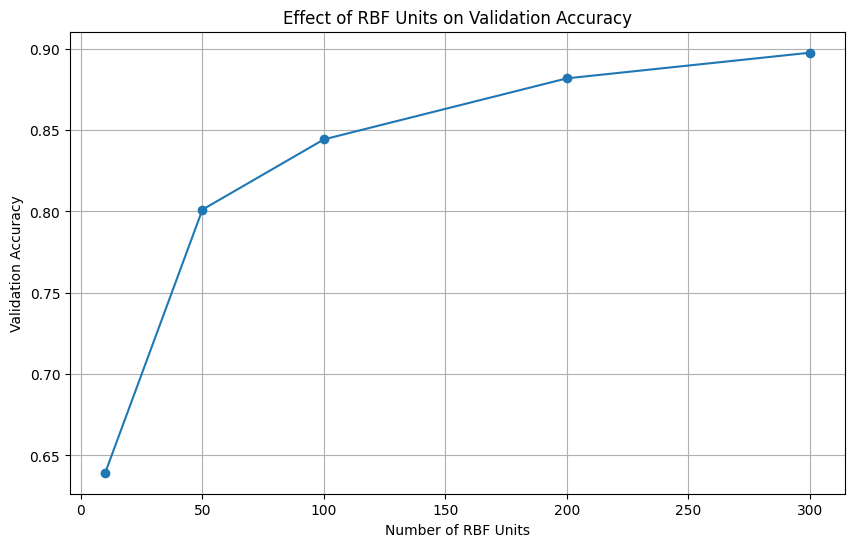

In [6]:
# Step 5: Analysis
# Effect of changing the number of RBF units on model performance
def analyze_rbf_units(k_values, X_train, y_train, X_val, y_val):
    accuracies = []
    for k in k_values:
        print(f"Training with {k} RBF units...")
        rbf_net = RBFNetwork(k=k, input_shape=X_train.shape[1], output_shape=10)
        rbf_net.fit(X_train, y_train)
        y_val_pred = rbf_net.predict(X_val)
        y_val_true = np.argmax(y_val, axis=1)
        accuracy = accuracy_score(y_val_true, y_val_pred)
        accuracies.append(accuracy)
        print(f"Validation Accuracy with {k} RBF units: {accuracy * 100:.2f}%")

    # Plot the effect of RBF units
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, accuracies, marker='o')
    plt.title('Effect of RBF Units on Validation Accuracy')
    plt.xlabel('Number of RBF Units')
    plt.ylabel('Validation Accuracy')
    plt.grid(True)
    plt.show()

# Test different numbers of RBF units
k_values = [10, 50, 100, 200, 300]
analyze_rbf_units(k_values, X_train, y_train, X_val, y_val)